In [1]:
#Intalling necessary libraries

!pip install autocorrect
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 2.2 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from autocorrect import Speller
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [3]:
print(tf.version.VERSION)
print(tf.keras.__version__)


2.6.0
2.6.0


In [4]:
#Reading input file

recipes = pd.read_csv("recipes.csv", sep=';')

In [5]:
recipes

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007
...,...,...,...,...,...,...,...,...,...,...
12346,Hot Coffee Frosting Recipe,5,https://images.media-allrecipes.com/userphotos...,Jean,30 m,30 m,1 h,"sugar,butter,cocoa powder,vanilla,coffee","'In a large bowl, combine confectioners'' suga...",27456
12347,White Chocolate Blueberry Cheesecake Recipe,78,https://images.media-allrecipes.com/userphotos...,Scott M.,20 m,1 h,1 h 20 m,"CRUST:,ham,almond,white sugar,butter,caramel,F...",Preheat oven to 275 degrees F (135 degrees C)....,27478
12348,'Aunt Anne''s Coffee Cake Recipe ',704,https://images.media-allrecipes.com/userphotos...,Mary,20 m,25 m,45 m,"flour,white sugar,baking powder,salt,butter,eg...",Preheat oven to 350 degrees F (175 degrees C)....,27491
12349,Giant Ding Dong Cake Recipe,157,https://images.media-allrecipes.com/userphotos...,TheThreeDogKitchen,25 m,50 m,2 h 15 m,"cake,chocolate,egg,water,vegetable oil,flour,m...",Preheat oven to 350 degrees F (175 degrees C)....,27511


In [6]:
#dropping unnecessary columns

df = recipes.drop(columns=['Recipe Name', 'Review Count', 'Author','Prepare Time','Cook Time','Total Time','RecipeID', 'Recipe Photo' ])


In [7]:
df

,Ingredients,Directions
0,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ..."
1,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...
2,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....
3,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....
4,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...
...,...,...
12346,"sugar,butter,cocoa powder,vanilla,coffee","'In a large bowl, combine confectioners'' suga..."
12347,"CRUST:,ham,almond,white sugar,butter,caramel,F...",Preheat oven to 275 degrees F (135 degrees C)....
12348,"flour,white sugar,baking powder,salt,butter,eg...",Preheat oven to 350 degrees F (175 degrees C)....
12349,"cake,chocolate,egg,water,vegetable oil,flour,m...",Preheat oven to 350 degrees F (175 degrees C)....


In [8]:
#Splitting data for later evaluation

eval_df = df[11000:]
eval_df.shape


(1351, 2)

In [9]:
#Train data

df = df[:11000]
df.shape

(11000, 2)

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])


In [11]:
df['Directions'] =df['Directions'].astype('str')

/Users/mesmek/.local/share/virtualenvs/store_time-uHvO0QHa/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.Directions.values

array(['Dissolve yeast in warm water.**Stir in sugar, salt, eggs, butter, and 2 cups of flour. Beat until smooth. Mix in remaining flour until smooth. Scrape dough from side of bowl. Knead dough, then cover it and let rise in a warm place until double (about 1 1/2 hours).**Punch down dough. Divide in half. Roll each half into a 12-inch circle. Spread with butter. Cut into 10 to 15 wedge. Roll up the wedges starting with the wide end. Place rolls with point under on a greased baking sheet. Cover and let rise until double (about 1 hour).**Bake at 400 degrees F (205 degrees C) for 12-15 minute or until golden brown. Brush tops with butter when they come out of the oven.**',
       "'Preheat oven to 350 degrees F (175 degrees C). Grease bottoms of two 9-inch loaf pans.**Mix together flour, salt, baking powder, poppy seeds, butter flavoring, oil, eggs, milk, sugar, vanilla, and almond flavoring. Pour into prepared pans.**Bake at 350 degrees F (175 degrees C) for one hour. Cool 5 minutes. Po

In [13]:
#Trying autocorrect library for spell checking

spell = Speller(lang='en')

print((spell('baking powder potata and tomata')))

baking powder potato and tomato


In [14]:
#Applying tokenizer and speller for recipes



#Since spell checking increases running time too much, I added spell checked version as a commented lines and
#trained without spell checking


#tokenized = [nlp(spell(t)) for t in df.Directions.values]
tokenized = [nlp(t) for t in df.Directions.values]

/Users/mesmek/.local/share/virtualenvs/store_time-uHvO0QHa/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [15]:
tokenized

[Dissolve yeast in warm water.**Stir in sugar, salt, eggs, butter, and 2 cups of flour. Beat until smooth. Mix in remaining flour until smooth. Scrape dough from side of bowl. Knead dough, then cover it and let rise in a warm place until double (about 1 1/2 hours).**Punch down dough. Divide in half. Roll each half into a 12-inch circle. Spread with butter. Cut into 10 to 15 wedge. Roll up the wedges starting with the wide end. Place rolls with point under on a greased baking sheet. Cover and let rise until double (about 1 hour).**Bake at 400 degrees F (205 degrees C) for 12-15 minute or until golden brown. Brush tops with butter when they come out of the oven.**,
 'Preheat oven to 350 degrees F (175 degrees C). Grease bottoms of two 9-inch loaf pans.**Mix together flour, salt, baking powder, poppy seeds, butter flavoring, oil, eggs, milk, sugar, vanilla, and almond flavoring. Pour into prepared pans.**Bake at 350 degrees F (175 degrees C) for one hour. Cool 5 minutes. Poke holes in top

In [16]:
#Building a vocabulary of tokens 

vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))


Number of unique tokens: 14462


In [17]:
vocab

{'<UNK>': 1,
 '<PAD>': 0,
 'Dissolve': 2,
 'yeast': 3,
 'in': 4,
 'warm': 5,
 'water.**Stir': 6,
 'sugar': 7,
 ',': 8,
 'salt': 9,
 'eggs': 10,
 'butter': 11,
 'and': 12,
 '2': 13,
 'cups': 14,
 'of': 15,
 'flour': 16,
 '.': 17,
 'Beat': 18,
 'until': 19,
 'smooth': 20,
 'Mix': 21,
 'remaining': 22,
 'Scrape': 23,
 'dough': 24,
 'from': 25,
 'side': 26,
 'bowl': 27,
 'Knead': 28,
 'then': 29,
 'cover': 30,
 'it': 31,
 'let': 32,
 'rise': 33,
 'a': 34,
 'place': 35,
 'double': 36,
 '(': 37,
 'about': 38,
 '1': 39,
 '1/2': 40,
 'hours).**Punch': 41,
 'down': 42,
 'Divide': 43,
 'half': 44,
 'Roll': 45,
 'each': 46,
 'into': 47,
 '12': 48,
 '-': 49,
 'inch': 50,
 'circle': 51,
 'Spread': 52,
 'with': 53,
 'Cut': 54,
 '10': 55,
 'to': 56,
 '15': 57,
 'wedge': 58,
 'up': 59,
 'the': 60,
 'wedges': 61,
 'starting': 62,
 'wide': 63,
 'end': 64,
 'Place': 65,
 'rolls': 66,
 'point': 67,
 'under': 68,
 'on': 69,
 'greased': 70,
 'baking': 71,
 'sheet': 72,
 'Cover': 73,
 'hour).**Bake': 74,
 'a

In [18]:
#Saving vocabulary of tokens

with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
        

In [19]:
ingredients_str = df.Ingredients

In [20]:
#Creating spell-checked labels


#Since spell checking increases running time too much, I added spell checked version as a commented lines and
#trained without spell checking

ingredients = []

for ingredients_items in ingredients_str:
    #spelled_ingredient = spell(ingredients_items)
    spelled_ingredient = ingredients_items
    value = spelled_ingredient.split(',')
    ingredients.append(value)

In [21]:
ingredients[0]

['yeast', 'water', 'white sugar', 'salt', 'egg', 'butter', 'flour', 'butter']

In [22]:
#Obtaining the ingredients position in the text

def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        #spell check here maybe for optimization for running time (future work)
        ci = ing
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels


In [23]:
labels = get_labels(ingredients, tokenized)


In [24]:
labels

[[False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,

In [25]:
set([t.text for t, l in zip(tokenized[1], labels[1]) if l])

{'almond',
 'butter',
 'eggs',
 'flour',
 'milk',
 'poppy',
 'salt',
 'sugar',
 'vanilla'}

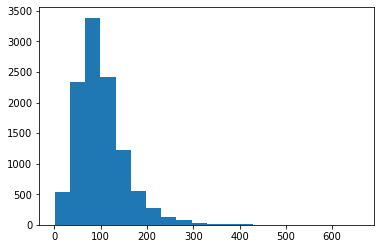

In [26]:
#Checking length of recipes for determination of padding lengths

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);


In [27]:
#Picked 400 as a maximum length

MAX_LEN = 400

In [28]:
#Padding the sequences and mapping the words to integers.

def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])


In [29]:
#Training features

X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)


In [30]:
X_seq[1]


array([ 95,  96,  93,  56,  97,  77,  78,  37,  98,  77,  80,  81,  17,
        99, 100,  15, 101, 102,  49,  50, 103, 104, 105,  16,   8,   9,
         8,  71, 106,   8, 107, 108,   8,  11, 109,   8, 110,   8,  10,
         8, 111,   8,   7,   8, 112,   8,  12, 113, 109,  17, 114,  47,
       115, 116,  75,  97,  77,  78,  37,  98,  77,  80,  81,  82, 117,
       118,  17, 119, 120, 121,  17, 122, 123,   4, 124,  15, 125,  12,
       126, 127, 128, 129, 127, 130,  21, 131, 132,   8,  40, 133,  11,
       109,   8,  40, 133, 113, 109,   8,  12,  39, 133, 112,  17, 134,
       135, 136, 137,   7,  56, 129, 127,  17,  94,  94,  95,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [31]:
X_seq.shape

(11000, 400)

In [32]:
#Training labels

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)


In [33]:
y_seq

array([[[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

# Simple 2-Layer LSTM based network

In [34]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))


2022-04-24 18:04:52.567380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [36]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          723100    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           129       
Total params: 880,925
Trainable params: 880,925
Non-trainable params: 0
__________________________________________________

In [37]:
#Training

history = model.fit(X_seq, y_seq, epochs=10, batch_size=256, validation_split=0.1)


Epoch 1/10


2022-04-24 18:04:55.105774: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


39/39 [==============================] - 106s 2s/step - loss: 0.0890 - accuracy: 0.9181 - val_loss: 0.0599 - val_accuracy: 0.9272
Epoch 2/10
39/39 [==============================] - 112s 3s/step - loss: 0.0601 - accuracy: 0.9332 - val_loss: 0.0509 - val_accuracy: 0.9267
Epoch 3/10
39/39 [==============================] - 124s 3s/step - loss: 0.0474 - accuracy: 0.9335 - val_loss: 0.0367 - val_accuracy: 0.9297
Epoch 4/10
39/39 [==============================] - 122s 3s/step - loss: 0.0235 - accuracy: 0.9636 - val_loss: 0.0135 - val_accuracy: 0.9796
Epoch 5/10
39/39 [==============================] - 126s 3s/step - loss: 0.0108 - accuracy: 0.9839 - val_loss: 0.0114 - val_accuracy: 0.9816
Epoch 6/10
39/39 [==============================] - 120s 3s/step - loss: 0.0097 - accuracy: 0.9853 - val_loss: 0.0108 - val_accuracy: 0.9830
Epoch 7/10
39/39 [==============================] - 123s 3s/step - loss: 0.0093 - accuracy: 0.9860 - val_loss: 0.0107 - val_accuracy: 0.9834
Epoch 8/10
39/39 [======

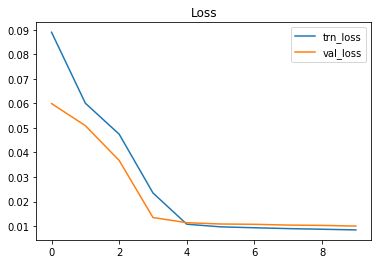

In [38]:
#Train and Validation Loss

plt.plot(history.history["loss"], label="trn_loss");
plt.plot(history.history["val_loss"], label="val_loss");
plt.legend();
plt.title("Loss");


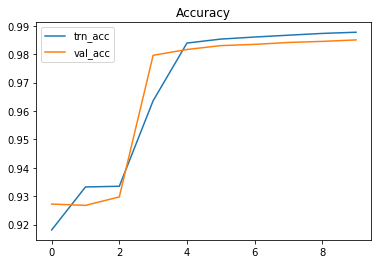

In [39]:
#Train and Validation Accuracy

plt.plot(history.history["accuracy"], label="trn_acc");
plt.plot(history.history["val_accuracy"], label="val_acc");
plt.legend();
plt.title("Accuracy");


In [40]:
#Saving the model

model.save('my_model.h5')

### Checking the predictions of the model

In [41]:
y_pred = model.predict(X_seq, verbose=1, batch_size=1024)


11/11 [==============================] - 35s 3s/step


In [42]:
i = 3
pred_i = y_pred[i] > 0.05


In [43]:
tokenized[i]


Preheat oven to 350 degrees F (175 degrees C).  Grease and flour an 8 1/2 x 4 1/2 inch loaf pan.**In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats.  Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.**

In [44]:
ingreds = [t.text for t, p in zip(tokenized[i], pred_i) if p]
print(set(ingreds))


{'nutmeg', 'sugar', 'raisins', 'eggs', 'salt', 'cinnamon', 'apple', 'oats', 'milk', 'flour'}


In [45]:
ingreds = [t.text for t, p in zip(tokenized[i], y_seq[i]) if p]
print(set(ingreds))


{'nutmeg', 'raisins', 'eggs', 'salt', 'cinnamon', 'apple', 'oats', 'milk', 'flour'}


In [46]:
ingredients[i]


['flour',
 'baking powder',
 'baking soda',
 'salt',
 'cinnamon',
 'nutmeg',
 'brown sugar',
 'oat',
 'apple',
 'walnut',
 'raisin',
 'egg',
 'milk',
 'vegetable oil']

### Test Data

In [47]:
eval_ingredients = eval_df.Ingredients.values


In [48]:
#Since spell checking increases running time too much, I added spell checked version as a commented lines and
#trained without spell checking

#eval_tokenized = [nlp(spell(t)) for t in eval_df.Directions.values]
eval_tokenized = [nlp(t) for t in eval_df.Directions.values]

X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)


/Users/mesmek/.local/share/virtualenvs/store_time-uHvO0QHa/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [49]:
y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=1024)


2/2 [==============================] - 4s 964ms/step


In [50]:
i = 759
pred_i = y_pred_test[i] > 0.05
print(eval_tokenized[i])
print()
print(eval_ingredients[i])
print()
ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
print(set(ingreds))


Mince apricots in a food processor.  Place in a bowl and toss with brown sugar.  Stir in 1/2 cup coconut and condensed milk.  Shape into 1 inch balls and roll in coconut.  Keep refrigerated.**

apricot,brown sugar,coconut,milk,coconut

{'apricots', 'sugar', 'milk', 'coconut'}


In [51]:
i = 354
pred_i = y_pred_test[i] > 0.05
print(eval_tokenized[i])
print()
print(eval_ingredients[i])
print()
ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
print(set(ingreds))


Preheat oven to 350 degrees F (175 degrees C). Grease and flour a 10 inch Bundt pan.**In a large bowl, stir together cake mix and poppy seeds. Make a well in the center and pour in yogurt, water, oil, sugar, eggs and lemon juice. Beat on low speed until blended. Scrape bowl, and beat 4 minutes on medium speed. Pour batter into prepared pan.**Bake in the preheated oven for 45 minutes, or until a toothpick inserted into the center of the cake comes out clean. Allow to cool.**

cake,poppy,yogurt,water,vegetable oil,sugar,egg,lemon juice

{'sugar', 'lemon', 'water', 'eggs', 'yogurt', 'poppy', 'flour', 'cake'}


## Testing Manuelly And Converting The Program In The Desired Way 

In [52]:
Recipes = {
  "recipe1": "In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.",
  "recipe2": "In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack. potato tomato"
}

In [53]:
print(Recipes)

{'recipe1': 'In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.', 'recipe2': 'In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack. potato tomato'}


In [54]:
def getList(dict):
    return dict.keys()
      
print(getList(Recipes))

dict_keys(['recipe1', 'recipe2'])


In [55]:
keys = getList(Recipes)
keys = list(keys)
recipe_list = []
for key in keys:
    recipe = Recipes[key]
    recipe_list.append(recipe)

In [56]:
type(keys)

list

In [57]:
recipe_list

['In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.',
 'In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack. potato tomato']

In [58]:
#Since spell checking increases running time too much, I added spell checked version as a commented lines and
#trained without spell checking

#eval_tokenized = [nlp(spell(t)) for t in recipe_list]
eval_tokenized = [nlp(t) for t in recipe_list]

X_seq_manuel = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)

In [59]:
y_pred_manuel = model.predict(X_seq_manuel, verbose=1, batch_size=1024)

1/1 [==============================] - 0s 78ms/step


In [61]:
Output = {}

for i in range(len(Recipes)):
    pred_i = y_pred_manuel[i] > 0.05
    #print(eval_tokenized[i])
    #print()
    ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
    ingreds = set(ingreds)
    #print(ingreds)
    output_list = []
    for j in ingreds:
        first = Recipes[keys[i]].find(j)
        last = first + len(j)
        output_list.append([j,first,last])
    Output[keys[i]] = output_list
        
    

In [62]:
Output

{'recipe1': [['nutmeg', 76, 82],
  ['sugar', 90, 95],
  ['raisins', 125, 132],
  ['eggs', 134, 138],
  ['salt', 60, 64],
  ['cinnamon', 66, 74],
  ['apple', 112, 117],
  ['oats', 102, 106],
  ['milk', 140, 144],
  ['flour', 25, 30]],
 'recipe2': [['nutmeg', 76, 82],
  ['sugar', 90, 95],
  ['tomato', 267, 273],
  ['raisins', 125, 132],
  ['potato', 260, 266],
  ['eggs', 134, 138],
  ['salt', 60, 64],
  ['cinnamon', 66, 74],
  ['apple', 112, 117],
  ['oats', 102, 106],
  ['milk', 140, 144],
  ['flour', 25, 30]]}